In [37]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from itertools import chain
import cv2

In [38]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation

# all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
# all_xray_df.sample(3)
df = pd.read_csv('data/sample_labels.csv')

df['age']=pd.to_numeric(df['Patient Age'].str[0:-1],errors='coerce')
df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,age
2644,00013282_004.png,Pneumothorax,4,13282,056Y,M,PA,2992,2991,0.143,0.143,56
81,00000468_005.png,Emphysema|Pneumothorax,5,468,031Y,M,PA,2992,2991,0.143,0.143,31
2228,00011460_021.png,Pneumothorax,21,11460,016Y,M,PA,2992,2991,0.143,0.143,16


EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Also, **describe your findings and how will you set up the model training based on the findings.**

## EDA

In [100]:
disease_labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
#disease_labels = [x for x in all_labels if len(x)>0]
#print(disease_labels)
for label in disease_labels:
#     if len(label)>1: # leave out empty labels
    df[label] = df['Finding Labels'].map(lambda x: 1 if label in x else 0)

### Demographic data such as age, gender, patient position,etc. (as it is available)

#### Age

count     5606
unique      92
top       058Y
freq       167
Name: Patient Age, dtype: object

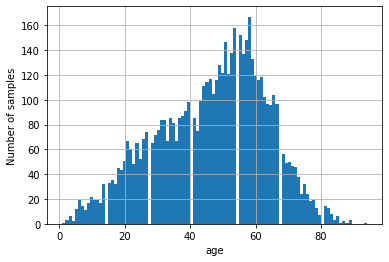

In [98]:
# Age distribution of all patients

def convert(x):
    '''assume that the first number is incorrect for ages above 110'''
    age_str, age = x['Patient Age'],x['age']
    age_aux=age
    if age_aux>110:
        age_aux=int(age_str[1:-1])
    
    return age_aux

# convert ages above 110 to lower ages by assuming and non-random consisting error in the data-collection process.
df.age=df[['Patient Age','age']].apply(lambda x: convert(x),axis=1)

df['age'].hist(bins=100)
plt.ylabel('Number of samples')
plt.xlabel('age')
df['Patient Age'].describe()

# df[['Patient Age','age']].sort_values(by=['age'])

#### Gender

In [40]:
df.groupby(['Patient Gender']).size()

Patient Gender
F    2472
M    3134
dtype: int64

#### The x-ray views taken (i.e. view position)

In [41]:
df.groupby(['View Position'])['Image Index'].count()

View Position
AP    2213
PA    3393
Name: Image Index, dtype: int64

### Number of pneumonia vs non-pneumonia cases:

In [99]:
df.groupby(['Pneumonia']).size()

Pneumonia
0    5544
1      62
dtype: int64

### The distribution of other diseases that are comorbid with pneumonia

Text(0.5, 1.0, 'Diseases comorbid with pneumonia')

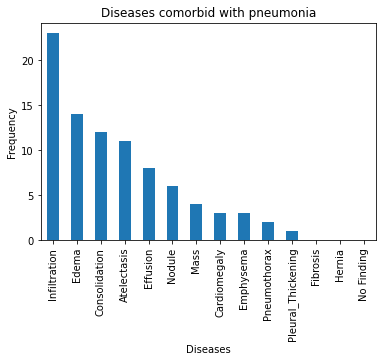

In [71]:
disease_labels2=list(disease_labels.copy())
disease_labels2.remove('Pneumonia')
df[df.Pneumonia==1][disease_labels2].sum().sort_values(ascending=False).plot.bar()
plt.ylabel('Frequency')
plt.xlabel('Diseases')
plt.title('Diseases comorbid with pneumonia')

### Number of disease per patient

In [112]:
df['total_disease']=df[disease_labels].sum(axis=1)
all=df.groupby(['Patient ID'])['total_disease'].sum().describe()
with_disease=df[df['Finding Labels']!='No Finding'].groupby(['Patient ID'])['total_disease'].sum().describe()
print('Disease count distribution per patient:')
print(with_disease)

Disease count distribution per patient:
count    1962.000000
mean        2.005097
std         1.672276
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        18.000000
Name: total_disease, dtype: float64


### Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

In [114]:
directory="./data/sample/images/"
fig,ax=plt.subplots(2,1,size=(10,10))


for disease in disease_labels:
    
    img_data=[]
    count_no_disease=1
    
    for index, row in df[df['Finding Labels']==disease].iterrows():
        fname = row['Image Index']
        img = cv2.imread(os.path.join(directory, fname))
#         plt.imshow(img)
#         plt.show()
        if count<=30:
            img_data=np.append(img_data,img.reshape(-1))
            count=count+1
        else:
            continue
        
    ax[0,1].hist(img_data, bins=50, density=True,label='{},n={} samples'.format(disease,count))
    ax[0,1].set_ylabel('Percentage')
    ax[0,1].xlabel('Pixel intensity level')    
    ax[0,1].title('Pixel histogram of xrays with only one condition:')
    

ax[0,1].hist(img_data, bins=50, density=True,label=disease)
ax[0,1].set_ylabel('Percentage')
ax[0,1].xlabel('Pixel intensity level')    
ax[0,1].title('Pixel histogram of xrays (n={} samples) with only:{}'.format(count,disease))


no_disease=[]
count_no_disease=0

for index, row in df[df['Finding Labels']=='No Fiding'].iterrows():
    fname = row['Image Index']
    img = cv2.imread(os.path.join(directory, fname))
    if count_no_disease<=30:
        no_disease=np.append(no_disease,img.reshape(-1))
        count_no_disease=count_no_disease+1
    else:
        continue
        
pneunomia=[]
pneunomia_alone=[]
no_pneunomia=[]
for index, row in df[(df['disease_total']==1) & (df['Finding Label']=='Pneumonia')].iterrows():
    fname = row['Image Index']
    img = cv2.imread(os.path.join(directory, fname))
#         plt.imshow(img)
#         plt.show()
    if count<=30:
        no_disease=np.append(no_disease,img.reshape(-1))
        count_no_disease=count_no_disease+1
    else:
        continue
    
plt.show()

TypeError: __init__() got an unexpected keyword argument 'size'

In [95]:
df['Finding Labels'].unique()

array(['Emphysema|Infiltration|Pleural_Thickening|Pneumothorax',
       'Cardiomegaly|Emphysema', 'No Finding', 'Atelectasis',
       'Cardiomegaly|Edema|Effusion', 'Consolidation|Mass', 'Effusion',
       'Consolidation|Effusion|Infiltration|Nodule', 'Mass',
       'Mass|Pneumothorax', 'Cardiomegaly|Consolidation', 'Consolidation',
       'Pneumothorax', 'Consolidation|Pleural_Thickening',
       'Infiltration|Nodule', 'Fibrosis', 'Infiltration', 'Emphysema',
       'Atelectasis|Infiltration|Mass|Pleural_Thickening',
       'Emphysema|Mass', 'Emphysema|Pneumothorax',
       'Emphysema|Infiltration', 'Consolidation|Effusion|Infiltration',
       'Consolidation|Fibrosis', 'Fibrosis|Pleural_Thickening',
       'Effusion|Infiltration', 'Nodule', 'Mass|Pleural_Thickening',
       'Infiltration|Pleural_Thickening', 'Pleural_Thickening',
       'Consolidation|Infiltration|Pneumothorax', 'Cardiomegaly|Effusion',
       'Atelectasis|Consolidation|Effusion', 'Fibrosis|Infiltration',
       'Ate